**Capstone Project - The Battle of Neighborhoods**

*Introduction/Business problem:*

What are the most common venues in World's major Central business districts (CBDs)? The answer to this question may be of interests to market researchers who will in turn provide the results to businesses who are intereted in finding out the most popular businesses to set up in CBDs in the world.

*Description of the data:*

In order to answer this question, we will explore the venue data from Foursquare for 3 World's CBDs and compare to find the most common venues:

Raffles Place (Singapore),
Midtown (Manhattan, New York),
Canary Wharf (London)

*Methodology:* 

1. Utlised the venue data (venue name and venue categories) from Foursquare for 3 CBDs and use python "intersection" function to seek for the common subset of the venue categories data. The common subset will be the most common venues amongst the 3 CBDs. 
2. Import Wordcloud to generate visualization of most popular venues based on frequency that each venue category appears in the merged list of venue data for all 3 CBDs. The more prominent the name of the venue appears in the Wordcloud image generated, the more popular the venue is. 

In [2]:
CLIENT_ID = '4JCOYMDTLXOR3IOVIG0EKSOQUDROEKY24UKCIWSQK0XCCYB2' # your Foursquare ID
CLIENT_SECRET = 'L0ZCARO4GP1DRDWZR1RJR0FU2QMG1RTGUY2RI1Q3P0S3AGVG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4JCOYMDTLXOR3IOVIG0EKSOQUDROEKY24UKCIWSQK0XCCYB2
CLIENT_SECRET:L0ZCARO4GP1DRDWZR1RJR0FU2QMG1RTGUY2RI1Q3P0S3AGVG


In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

In [4]:
#Singapore Central business district is Raffles Place
lat=1.2837
long=103.8509
#London Central business district is Canary Wharf
lat1=51.5061
long1=-0.0158
#New York Central business district in Manhattan is Midtown
lat2=40.754932
long2=-73.984016

In [5]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    long, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=4JCOYMDTLXOR3IOVIG0EKSOQUDROEKY24UKCIWSQK0XCCYB2&client_secret=L0ZCARO4GP1DRDWZR1RJR0FU2QMG1RTGUY2RI1Q3P0S3AGVG&v=20180605&ll=1.2837,103.8509&radius=500&limit=100'

In [6]:
url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat1, 
    long1, 
    radius, 
    LIMIT)
url1 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=4JCOYMDTLXOR3IOVIG0EKSOQUDROEKY24UKCIWSQK0XCCYB2&client_secret=L0ZCARO4GP1DRDWZR1RJR0FU2QMG1RTGUY2RI1Q3P0S3AGVG&v=20180605&ll=51.5061,-0.0158&radius=500&limit=100'

In [7]:
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat2, 
    long2, 
    radius, 
    LIMIT)
url2 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=4JCOYMDTLXOR3IOVIG0EKSOQUDROEKY24UKCIWSQK0XCCYB2&client_secret=L0ZCARO4GP1DRDWZR1RJR0FU2QMG1RTGUY2RI1Q3P0S3AGVG&v=20180605&ll=40.754932,-73.984016&radius=500&limit=100'

In [8]:
results = requests.get(url).json()
results1 = requests.get(url1).json()
results2 = requests.get(url2).json()

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Singapore CBD-Rafles Place's list of venues

In [10]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,City Hot Pot,Hotpot Restaurant,1.284173,103.851585
1,CULINARYON,Comfort Food Restaurant,1.284876,103.850933
2,Virgin Active,Gym / Fitness Center,1.284608,103.850815
3,Fat Saigon Boy,Vietnamese Restaurant,1.282977,103.849068
4,The Salad Shop,Salad Place,1.285523,103.851177


In [11]:
Raffles_Place_list=list(nearby_venues['categories'].unique())
Raffles_Place_list

['Hotpot Restaurant',
 'Comfort Food Restaurant',
 'Gym / Fitness Center',
 'Vietnamese Restaurant',
 'Salad Place',
 'Hotel',
 'Cocktail Bar',
 'Modern European Restaurant',
 'Lounge',
 'Japanese Restaurant',
 'Waterfront',
 'Bar',
 'Café',
 'Gym',
 'Bridge',
 'Chinese Restaurant',
 'Martial Arts School',
 'Italian Restaurant',
 'Seafood Restaurant',
 'Yoga Studio',
 'Korean Restaurant',
 'French Restaurant',
 'Building',
 'Massage Studio',
 'Street Food Gathering',
 'Beer Garden',
 'Mexican Restaurant',
 'Plaza',
 'History Museum',
 'Sandwich Place',
 'Wine Bar',
 'Restaurant',
 'Food Court',
 'Coffee Shop',
 'Hotel Bar',
 'Nightclub',
 'Canal',
 'Cupcake Shop',
 'Speakeasy',
 'Australian Restaurant',
 'Pub',
 'Dumpling Restaurant',
 'Peking Duck Restaurant',
 'Asian Restaurant',
 'Greek Restaurant',
 'Szechuan Restaurant',
 'Cantonese Restaurant',
 'Temple']

London CBD-Canary Wharf's list of venues

In [12]:
venues1 = results1['response']['groups'][0]['items']
    
nearby_venues1 = json_normalize(venues1) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues1 =nearby_venues1.loc[:, filtered_columns]

# filter the category for each row
nearby_venues1['venue.categories'] = nearby_venues1.apply(get_category_type, axis=1)

# clean columns
nearby_venues1.columns = [col.split(".")[-1] for col in nearby_venues1.columns]

nearby_venues1.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Billingsgate Market,Fish Market,51.506312,-0.014184
1,Crossrail Place Roof Garden,Garden,51.505965,-0.016822
2,Sticks'n'Sushi,Sushi Restaurant,51.506178,-0.018287
3,Ippudo,Ramen Restaurant,51.505982,-0.018141
4,BrewDog Canary Wharf,Beer Bar,51.504447,-0.015185


In [13]:
Canary_Wharf_list=list(nearby_venues1['categories'].unique())
Canary_Wharf_list

['Fish Market',
 'Garden',
 'Sushi Restaurant',
 'Ramen Restaurant',
 'Beer Bar',
 'Supermarket',
 'Movie Theater',
 'Speakeasy',
 'Shopping Mall',
 'Cycle Studio',
 'Gym / Fitness Center',
 'Japanese Restaurant',
 'Poke Place',
 'Indian Restaurant',
 'Pizza Place',
 'Coffee Shop',
 'Bakery',
 'Mexican Restaurant',
 'Hotel',
 'Park',
 'English Restaurant',
 'Italian Restaurant',
 'Gift Shop',
 'Juice Bar',
 'Steakhouse',
 'Smoothie Shop',
 'Plaza',
 'Spanish Restaurant',
 'Street Food Gathering',
 'Fried Chicken Joint',
 'Scenic Lookout',
 'Burger Joint',
 'Donut Shop',
 'Sandwich Place',
 'Bar',
 'Salad Place',
 'Breakfast Spot',
 'Jewelry Store',
 'Dumpling Restaurant',
 'Chocolate Shop',
 'Hotel Bar',
 'Tennis Court',
 'Bookstore',
 'Vietnamese Restaurant',
 'Deli / Bodega',
 'Falafel Restaurant',
 'Restaurant',
 'Fast Food Restaurant',
 'Café',
 'Asian Restaurant',
 'Portuguese Restaurant',
 'Greek Restaurant',
 'Stationery Store',
 'French Restaurant',
 'Pharmacy',
 'Grocery Store

Manhattan, New York-CBD Midtown's list of venues

In [14]:
venues2 = results2['response']['groups'][0]['items']
    
nearby_venues2 = json_normalize(venues2) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues2 =nearby_venues2.loc[:, filtered_columns]

# filter the category for each row
nearby_venues2['venue.categories'] = nearby_venues2.apply(get_category_type, axis=1)

# clean columns
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]

nearby_venues2.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Bryant Park,Park,40.753621,-73.983265
1,Books Kinokuniya,Bookstore,40.754053,-73.984649
2,Belasco Theatre,Theater,40.756548,-73.983923
3,Blue Bottle Coffee,Coffee Shop,40.753027,-73.984140
4,sweetgreen,Salad Place,40.754640,-73.983102


In [15]:
Midtown_list=list(nearby_venues2['categories'].unique())
Midtown_list

['Park',
 'Bookstore',
 'Theater',
 'Coffee Shop',
 'Salad Place',
 'Grocery Store',
 'French Restaurant',
 'Mediterranean Restaurant',
 'Hotel',
 'Japanese Restaurant',
 'Gym',
 'Cycle Studio',
 'Pharmacy',
 'Bakery',
 'Café',
 'Pizza Place',
 'Cosmetics Shop',
 'Burrito Place',
 'Historic Site',
 'Chinese Restaurant',
 'Plaza',
 'Pilates Studio',
 'Sushi Restaurant',
 'Shoe Store',
 'Concert Hall',
 'Indian Restaurant',
 'Steakhouse',
 'Deli / Bodega',
 'Clothing Store',
 'Bar',
 'Comic Shop',
 'American Restaurant',
 'Miscellaneous Shop',
 'Szechuan Restaurant',
 'Juice Bar',
 'Mexican Restaurant',
 'Spa',
 'Cuban Restaurant',
 'Yoga Studio',
 'Smoke Shop',
 'Burger Joint',
 'Food Stand',
 'Art Gallery',
 'Tailor Shop',
 'Lounge',
 'Taco Place',
 'Office',
 'South American Restaurant',
 'Fast Food Restaurant',
 'Theme Restaurant',
 'Seafood Restaurant',
 'BBQ Joint',
 'Martial Arts School',
 'Arts & Crafts Store',
 'Sporting Goods Shop',
 'Exhibit',
 'Music Store',
 'Sandwich Place'

In [16]:
common1=list(set(Raffles_Place_list).intersection(Midtown_list))
common1

['Lounge',
 'Sandwich Place',
 'Plaza',
 'Gym',
 'Hotel',
 'Bar',
 'Yoga Studio',
 'Szechuan Restaurant',
 'Café',
 'French Restaurant',
 'Coffee Shop',
 'Salad Place',
 'Chinese Restaurant',
 'Seafood Restaurant',
 'Martial Arts School',
 'Mexican Restaurant',
 'Japanese Restaurant']

In [17]:
common2=list(set(Raffles_Place_list).intersection(Canary_Wharf_list))
common2

['Dumpling Restaurant',
 'Plaza',
 'Bar',
 'Hotel',
 'Street Food Gathering',
 'Gym / Fitness Center',
 'Speakeasy',
 'Vietnamese Restaurant',
 'Café',
 'Greek Restaurant',
 'French Restaurant',
 'Japanese Restaurant',
 'Italian Restaurant',
 'Hotel Bar',
 'Restaurant',
 'Coffee Shop',
 'Salad Place',
 'Asian Restaurant',
 'Sandwich Place',
 'Mexican Restaurant']

In [18]:
common3=list(set(Midtown_list).intersection(Canary_Wharf_list))
common3

['Bar',
 'Bakery',
 'Juice Bar',
 'Sandwich Place',
 'Sushi Restaurant',
 'Japanese Restaurant',
 'Park',
 'French Restaurant',
 'Pharmacy',
 'Pizza Place',
 'Deli / Bodega',
 'Coffee Shop',
 'Salad Place',
 'Mexican Restaurant',
 'Plaza',
 'Hotel',
 'Café',
 'Bookstore',
 'Steakhouse',
 'Cycle Studio',
 'Burger Joint',
 'Grocery Store',
 'Fast Food Restaurant',
 'Indian Restaurant']

Most common venues in 3 major Central business districts (CBDs) in the World are:

In [19]:
common_venues=list(set(common1).intersection(common2))
common_venues

['Plaza',
 'Bar',
 'Hotel',
 'Café',
 'French Restaurant',
 'Coffee Shop',
 'Salad Place',
 'Sandwich Place',
 'Mexican Restaurant',
 'Japanese Restaurant']

Most popular venues in terms of frequency?

In [20]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

print ('Wordcloud is installed and imported!')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         324 KB

The following NEW packages will be INSTALLED:

  wordcloud          conda-forge/linux-64::wordcloud-1.4.1-py36_0



wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done

In [40]:
# import package
from wordcloud import WordCloud

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.3.0


In [21]:
all_venues=pd.concat([nearby_venues,nearby_venues1,nearby_venues2])
all_venues.head()

,name,categories,lat,lng
0,City Hot Pot,Hotpot Restaurant,1.284173,103.851585
1,CULINARYON,Comfort Food Restaurant,1.284876,103.850933
2,Virgin Active,Gym / Fitness Center,1.284608,103.850815
3,Fat Saigon Boy,Vietnamese Restaurant,1.282977,103.849068
4,The Salad Shop,Salad Place,1.285523,103.851177


In [22]:
count=pd.DataFrame(all_venues['categories'].value_counts())
count.head()

,categories
Coffee Shop,17
Hotel,13
Theater,9
Café,7
Sandwich Place,6


In [23]:
count1=count.reset_index()
count1.head()

,index,categories
0,Coffee Shop,17
1,Hotel,13
2,Theater,9
3,Café,7
4,Sandwich Place,6


In [24]:
count1.columns=['categories','count']
count1.head()

,categories,count
0,Coffee Shop,17
1,Hotel,13
2,Theater,9
3,Café,7
4,Sandwich Place,6


In [25]:
count1['count'].sum()

264

In [33]:
max_words = 90
word_string = '*'
for i in count1.index.values:
        repeat_num_times = int(count1.loc[i, 'count']/264*max_words)
        word_string = word_string + ((count1['categories'] + '*') * repeat_num_times)
                                     
# display the generated text
word_string

0      *Coffee Shop*Coffee Shop*Coffee Shop*Coffee Sh...
1      *Hotel*Hotel*Hotel*Hotel*Hotel*Hotel*Hotel*Hot...
2      *Theater*Theater*Theater*Theater*Theater*Theat...
3      *Café*Café*Café*Café*Café*Café*Café*Café*Café*...
4      *Sandwich Place*Sandwich Place*Sandwich Place*...
5      *Japanese Restaurant*Japanese Restaurant*Japan...
6      *Plaza*Plaza*Plaza*Plaza*Plaza*Plaza*Plaza*Pla...
7      *Gym / Fitness Center*Gym / Fitness Center*Gym...
8      *Sushi Restaurant*Sushi Restaurant*Sushi Resta...
9      *Park*Park*Park*Park*Park*Park*Park*Park*Park*...
10     *French Restaurant*French Restaurant*French Re...
11     *Bookstore*Bookstore*Bookstore*Bookstore*Books...
12     *Salad Place*Salad Place*Salad Place*Salad Pla...
13     *Italian Restaurant*Italian Restaurant*Italian...
14     *Bakery*Bakery*Bakery*Bakery*Bakery*Bakery*Bak...
15     *Gym*Gym*Gym*Gym*Gym*Gym*Gym*Gym*Gym*Gym*Gym*G...
16     *Clothing Store*Clothing Store*Clothing Store*...
17     *Burger Joint*Burger Joi

In [38]:
# create the word cloud
wc = WordCloud(
    background_color='white',
    max_words=2000
)
wc = WordCloud(background_color='white').generate(str(word_string))

print('Word cloud created!')

Word cloud created!


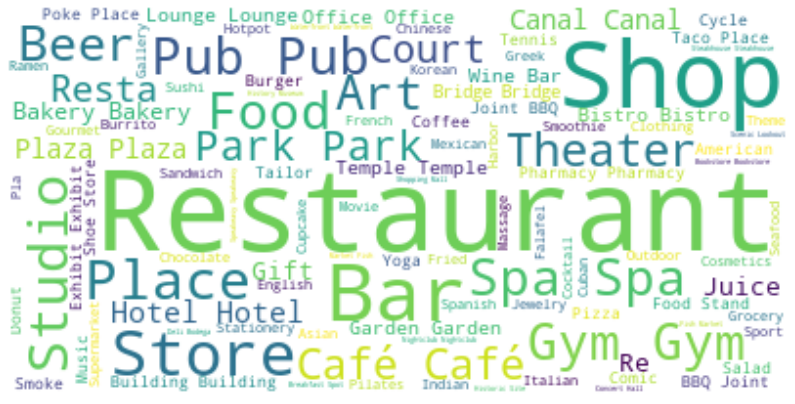

In [43]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

**Observation and Conclusion:**

Based on the results of most common venues from the 3 CBDs, we can have a few recommendations for potential business ideas in CBDs:

Risk-averse business owners may be more keen to opening businesses that have been proven to be popular in CBDs as shown in the list of most common venues above.
Risk-lovers, in opposite, may prefer to open businesses that are not yet too common and thus may want to introduce something more unique.
